In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:

# Read the features dataframe from CSV
playlists_df = pd.read_csv('/content/drive/MyDrive/Spotify_Data/playlist_df.csv')
tracks_df = pd.read_csv('/content/drive/MyDrive/Spotify_Data/final_tracks_data.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/Spotify_Data/ratings_df.csv')
complete_feature_set = pd.read_csv('/content/drive/MyDrive/Spotify_Data/complete_feature.csv')

In [3]:
playlist_track_df = pd.read_csv('/content/drive/MyDrive/Spotify_Data/playlist_track_info.csv')
playlist_track_df.columns

Index(['artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri',
       'album_name', 'track_id', 'genres', 'artist_popularity', 'release_date',
       'release_year', 'release_year_bucket', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms_x', 'time_signature',
       'pid', 'pos', 'num_followers_x', 'Unnamed: 0', 'name', 'collaborative',
       'modified_at', 'num_tracks', 'num_albums', 'num_followers_y',
       'num_edits', 'duration_ms_y', 'num_artists'],
      dtype='object')

In [4]:
def clean_dataframe(df):

    columns_to_remove = [
        'track_uri', 'artist_uri', 'album_uri', 'release_date',
        'release_year', 'time_signature', 'num_followers',
        'collaborative', 'modified_at', 'num_tracks',
        'num_albums', 'num_artists'
    ]
    df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])
    # Remove columns that start with 'Unnamed'
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Rename columns that end with '_y'
    df.rename(columns=lambda x: x.rstrip('_x') if '_x' in x else x, inplace=True)

    df = df[df.columns.drop(list(df.filter(regex='_y$')))]

    # Remove duplicate columns by column name
    df = df.loc[:,~df.columns.duplicated()]

    return df

playlists_df = clean_dataframe(playlists_df)
tracks_df = clean_dataframe(tracks_df)
ratings_df = clean_dataframe(ratings_df)
complete_feature_set = clean_dataframe(complete_feature_set)
playlist_track_df = clean_dataframe(playlist_track_df)

In [5]:
playlist_track_df.columns

Index(['artist_name', 'track_name', 'album_name', 'track_id', 'genres',
       'artist_popularity', 'release_year_bucket', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'pid', 'pos', 'num_followers', 'name', 'num_edits'],
      dtype='object')

In [6]:
from scipy.stats import mstats

def avg_duration(df):
    # Winsorizing the duration_ms column to reduce the effect of outliers
    df['winsorized_duration'] = mstats.winsorize(df['duration_ms'], limits=[0.05, 0.05])

    # Compute the average of the winsorized duration for each pid
    avg_duration_per_pid = df.groupby('pid')['winsorized_duration'].mean().reset_index()

    # Convert average duration from milliseconds to minutes
    avg_duration_per_pid['avg_duration_minutes'] = avg_duration_per_pid['winsorized_duration'] / 60000

    avg_duration_per_pid = avg_duration_per_pid.drop(columns=['winsorized_duration'])

    # Merge the average winsorized duration in minutes back into the original dataframe
    df = df.merge(avg_duration_per_pid, on='pid', how='left')

    # Drop the original and winsorized duration columns
    df = df.drop(columns=['duration_ms', 'winsorized_duration'])
    return df


In [7]:
playlist_track_df = avg_duration(playlist_track_df)

In [8]:
playlist_track_df.isna().sum()

artist_name              0
track_name               0
album_name               0
track_id                 0
genres                   0
artist_popularity        0
release_year_bucket      0
danceability             0
energy                   0
key                      0
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness         0
liveness                 0
valence                  0
tempo                    0
pid                      0
pos                      0
num_followers            0
name                    21
num_edits                0
avg_duration_minutes     0
dtype: int64

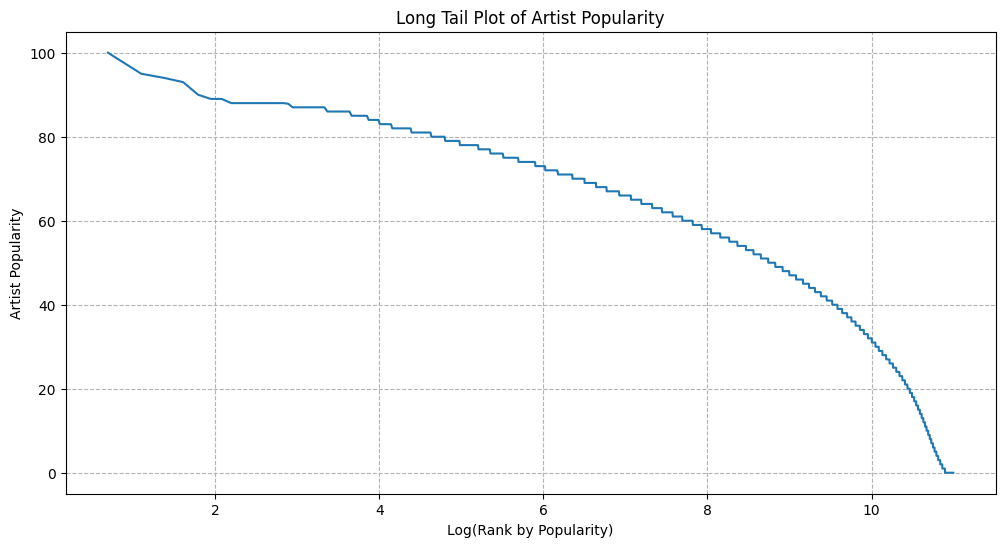

In [9]:
# Group by artist and playlist to get unique occurrences within each playlist
unique_artist_in_playlist = playlist_track_df.drop_duplicates(subset=['artist_name', 'pid'])

# Count the occurrences for each artist (unique for a playlist)
artist_counts = unique_artist_in_playlist['artist_name'].value_counts()

# Group by artist and calculate their mean popularity
artist_popularity = playlist_track_df.groupby('artist_name')['artist_popularity'].mean()

# Merge popularity with counts
merged = pd.concat([artist_popularity, artist_counts], axis=1)
merged.columns = ['popularity', 'counts']

# Drop NaN values (if any) and sort by popularity
merged = merged.dropna().sort_values(by='popularity', ascending=False)

# Rank by popularity
merged['rank'] = range(1, len(merged) + 1)

# Plotting: x-axis has rank in log scale and y-axis has popularity
plt.figure(figsize=(12, 6))
plt.plot(np.log1p(merged['rank']), merged['popularity'])
plt.title('Long Tail Plot of Artist Popularity')
plt.xlabel('Log(Rank by Popularity)')
plt.ylabel('Artist Popularity')
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()


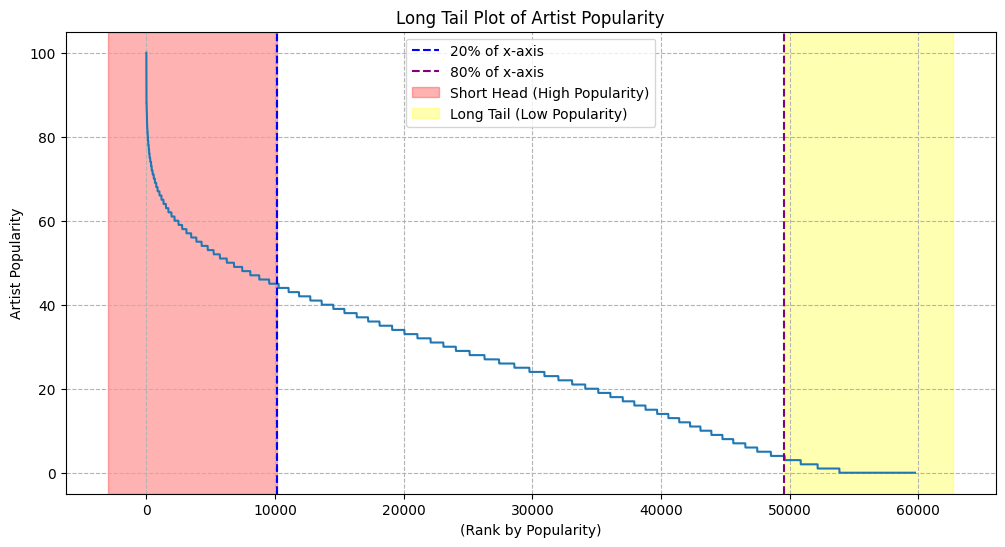

In [10]:
import matplotlib.pyplot as plt

# Your data and plotting code
plt.figure(figsize=(12, 6))
plt.plot(merged['rank'], merged['popularity'])
plt.title('Long Tail Plot of Artist Popularity')
plt.xlabel('(Rank by Popularity)')
plt.ylabel('Artist Popularity')
plt.grid(True, which="both", ls="--", c='0.7')

# Calculate positions for lines at 20% and 80%
x_min, x_max = plt.xlim()
line_20_percent = 0.2 * (x_max - x_min) + x_min
line_80_percent = 0.8 * (x_max - x_min) + x_min

# Draw lines at 20% and 80% of the x-axis with labels
plt.axvline(x=line_20_percent, color='blue', linestyle='--', label='20% of x-axis', zorder=5) # High popularity
plt.axvline(x=line_80_percent, color='purple', linestyle='--', label='80% of x-axis', zorder=5) # Low popularity

# Highlight the short head (high popularity) region in red
plt.axvspan(x_min, line_20_percent, color='red', alpha=0.3, label='Short Head (High Popularity)')

# Highlight the long tail (low popularity) region in yellow
plt.axvspan(line_80_percent, x_max, color='yellow', alpha=0.3, label='Long Tail (Low Popularity)')

# Show the plot with legend
plt.legend()
plt.show()


In [11]:
!pip install powerlaw

In [12]:
import powerlaw
# Fit a power law distribution to the data
fit = powerlaw.Fit(merged['popularity'])

# Get the estimated exponent for the power law distribution
alpha = fit.alpha

# Print the estimated exponent
print(f"Estimated Power Law Exponent (Alpha): {alpha:.4f}")

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Estimated Power Law Exponent (Alpha): 10.0895


In [13]:
fit = powerlaw.Fit(merged['popularity'])

# Calculate the KS statistic
ks_statistic = fit.D

# Calculate the maximum likelihood estimation (MLE) of Alpha
alpha_mle = fit.alpha

# Print the results
print(f"Kolmogorov-Smirnov (KS) Statistic: {ks_statistic:.4f}")
print(f"Maximum Likelihood Estimation (MLE) of Alpha: {alpha_mle:.4f}")

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Kolmogorov-Smirnov (KS) Statistic: 0.0796
Maximum Likelihood Estimation (MLE) of Alpha: 10.0895


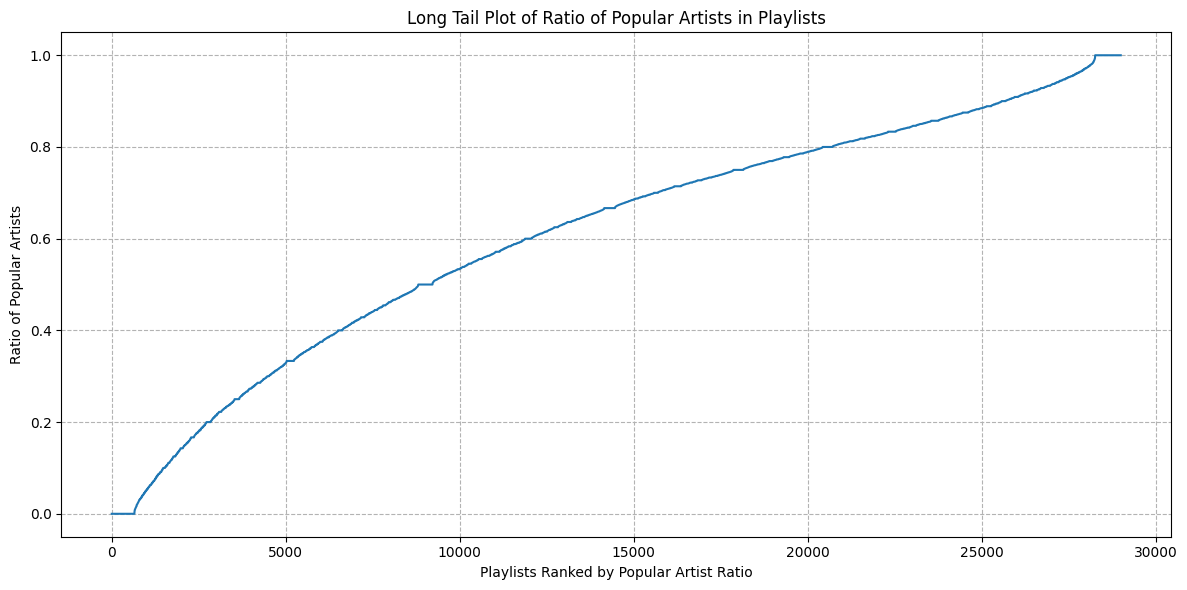

In [14]:
import matplotlib.pyplot as plt

# Define the threshold for popular artists
popularity_threshold = 60

# Mark rows where the artist is popular
playlist_track_df['is_popular'] = playlist_track_df['artist_popularity'] > popularity_threshold

# Calculate the ratio of popular artists in each playlist
popular_ratio = playlist_track_df.groupby('pid')['is_popular'].mean().reset_index()

# Sort playlists by popular artist ratio
popular_ratio = popular_ratio.sort_values(by='is_popular', ascending=True)

# Plotting the long tail
plt.figure(figsize=(12, 6))
plt.plot(range(len(popular_ratio)), popular_ratio['is_popular'])
plt.title('Long Tail Plot of Ratio of Popular Artists in Playlists')
plt.xlabel('Playlists Ranked by Popular Artist Ratio')
plt.ylabel('Ratio of Popular Artists')
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()


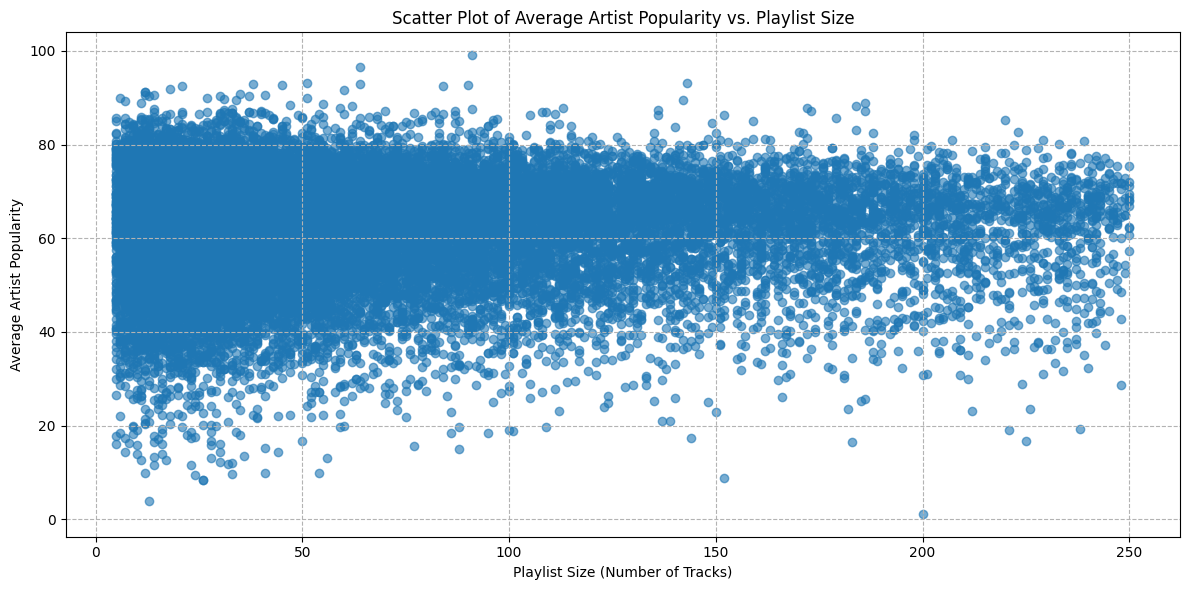

In [15]:
import matplotlib.pyplot as plt

# Calculate the average artist popularity for each playlist
avg_popularity = playlist_track_df.groupby('pid')['artist_popularity'].mean().reset_index()
avg_popularity.columns = ['pid', 'avg_artist_popularity']

# Calculate the size (number of tracks) of each playlist
playlist_size = playlist_track_df.groupby('pid').size().reset_index()
playlist_size.columns = ['pid', 'playlist_size']

# Merge the two dataframes
merged = avg_popularity.merge(playlist_size, on='pid')

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(merged['playlist_size'], merged['avg_artist_popularity'], alpha=0.6)
plt.title('Scatter Plot of Average Artist Popularity vs. Playlist Size')
plt.xlabel('Playlist Size (Number of Tracks)')
plt.ylabel('Average Artist Popularity')
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def precompute_clusters(tracks_df, n_clusters):
    # Keep only numerical columns in tracks_df
    tracks_df_numeric = tracks_df.select_dtypes(include=[np.number])
    #tracks_df_numeric = tracks_df_numeric.drop(columns = ['artist_popularity'])

    # Fit and transform the scaler on tracks_df
    scaler = StandardScaler()
    tracks_df_scaled = scaler.fit_transform(tracks_df_numeric)
    # Train KMeans model on tracks_df
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(tracks_df_scaled)

    # Predict clusters for tracks_df
    clusters = kmeans_model.predict(tracks_df_scaled)

    # Add cluster column to tracks_df
    tracks_df['cluster'] = clusters

    return kmeans_model, tracks_df, scaler

In [18]:
kmeans_model, tracks_df_clustered, scaler = precompute_clusters(complete_feature_set, n_clusters = 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend_songs1(kmeans_model, tracks_df_clustered, playlist_df, scaler):
    # Ensure that the number of clusters specified in kmeans_model matches the actual number of clusters
    n_clusters = kmeans_model.n_clusters

    # Calculate cosine similarities between playlist cluster centroids and all tracks
    def calculate_cosine_similarities(cluster_centers, tracks):
        return cosine_similarity(tracks.drop(columns=['cluster']), cluster_centers)

    # Find song features in the playlist
    playlist_features = tracks_df_clustered[tracks_df_clustered['track_id'].isin(playlist_df['track_id'].values)]

    # Keep only numerical columns in playlist_features
    playlist_features_numeric = playlist_features.select_dtypes(include=[np.number])
    #playlist_features_numeric = playlist_features_numeric.drop(columns=['artist_popularity'])

    # Scale playlist features using the same scaler fitted on the entire database
    playlist_features_scaled = scaler.transform(playlist_features_numeric.drop(columns=['cluster']))

    # Cluster songs in the playlist into n_clusters
    kmeans_playlist = KMeans(n_clusters=n_clusters, random_state=0).fit(playlist_features_scaled)
    playlist_cluster_centers = kmeans_playlist.cluster_centers_

    # Calculate cosine similarities between playlist cluster centroids and all tracks
    cosine_similarities = calculate_cosine_similarities(playlist_cluster_centers, tracks_df_clustered)

    # Identify closest cluster in tracks_df_clustered for each playlist cluster centroid
    closest_clusters = np.argmax(cosine_similarities, axis=1)

    # Calculate cluster sizes for playlist_df clusters
    playlist_cluster_sizes = np.bincount(kmeans_playlist.labels_)

    # Filter tracks_df_clustered to only include songs that are not in the playlist
    recommendations = tracks_df_clustered[~tracks_df_clustered['track_id'].isin(playlist_df['track_id'].values)]

    # Calculate total number of songs to recommend
    total_songs_to_recommend = 200

    # Collecting distinct songs for each identified cluster
    final_recommendations = []

    for playlist_centroid, closest_cluster in enumerate(closest_clusters):
        cluster_size = playlist_cluster_sizes[closest_cluster]
        cluster_track_indices = recommendations[recommendations['cluster'] == closest_cluster].index
        cluster_track_similarities = cosine_similarities[ cluster_track_indices, closest_cluster]  # Fix indexing here
        sorted_track_indices = np.argsort(cluster_track_similarities)[::-1]
        sorted_cluster_tracks = cluster_track_indices[sorted_track_indices]

        # Calculate the number of songs to recommend from this cluster based on the cluster size
        num_songs_to_recommend = int((cluster_size / sum(playlist_cluster_sizes)) * total_songs_to_recommend)

        # Sort the tracks by similarity and select the top songs to recommend
        recommended_track_indices = sorted_track_indices[:num_songs_to_recommend]

        # Append the recommended tracks to the final list
        final_recommendations.extend(cluster_track_indices[recommended_track_indices])

        # Break if enough recommendations are collected
        if len(final_recommendations) >= total_songs_to_recommend:
            break

    # Convert set of track IDs back to a DataFrame for recommendations
    recommendations_df = tracks_df_clustered[tracks_df_clustered['track_id'].isin(final_recommendations)]

    # Add the 'pid' column to recommendations_df
    recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]


    # Filter tracks_df_clustered to include only the original playlist
    original_playlist_df = tracks_df_clustered[tracks_df_clustered['track_id'].isin(playlist_df['track_id'].values)]

    # Add the 'pid' column to original_playlist_df
    original_playlist_df['pid'] = playlist_df['pid'].values[0]

    # Concatenate the original and recommended songs into a single DataFrame
    combined_df = pd.concat([original_playlist_df, recommendations_df], ignore_index=True)

    combined_df['pid'] = playlist_df['pid'].values[0]

    return recommendations_df, combined_df


In [20]:
unique_pid = playlist_track_df['pid'].unique()


In [21]:
import pandas as pd

low_threshold = 45
medium_threshold = 65

def classify_popularity(value, low_threshold, medium_threshold):
    if value <= low_threshold:
        return 'low'
    elif value <= medium_threshold:
        return 'medium'
    else:
        return 'high'

def calculate_popularity_ratios(df, tracks_df, low_threshold, medium_threshold):
    # Merge df with tracks_df to get the real artist popularity values
    df = df.merge(tracks_df[['track_id', 'artist_popularity']], on='track_id', how='left')
    # Classify popularity based on artist_popularity
    df['popularity_group'] = df['artist_popularity_y'].apply(classify_popularity, args=(low_threshold, medium_threshold))

    # Calculate popularity ratios
    popularity_counts = df['popularity_group'].value_counts()

    # Ensure that all three categories are present in the counts
    for category in ['low', 'medium', 'high']:
        if category not in popularity_counts:
            popularity_counts[category] = 0

    # Calculate normalized popularity ratios
    popularity_ratios = popularity_counts / popularity_counts.sum()

    return popularity_ratios


def get_recommendations_for_category(category_playlists, kmeans_model, tracks_df_clustered, scaler, low_threshold, medium_threshold):
    recommendations = {}

    for playlist_df in category_playlists:
        # Add 'pid' to the DataFrame before passing it to recommend_songs1
        playlist_df_with_pid = playlist_df.copy()
        playlist_pid = playlist_df['pid'].values[0] # Assuming all rows in the playlist have the same 'pid'
        playlist_df_with_pid['pid'] = playlist_pid

        recommendations_df, combined_df = recommend_songs1(kmeans_model, tracks_df_clustered, playlist_df_with_pid, scaler)

        # Calculate popularity ratios for low, medium, and high based on artist_popularity
        combined_popularity_ratios = calculate_popularity_ratios(combined_df, tracks_df, low_threshold, medium_threshold)
        recommendations_popularity_ratios = calculate_popularity_ratios(recommendations_df, tracks_df, low_threshold, medium_threshold)
        original_popularity_ratios = calculate_popularity_ratios(playlist_df_with_pid, tracks_df, low_threshold, medium_threshold)
        print(original_popularity_ratios)
        recommendations[playlist_pid] = {
            'original_playlist': playlist_df_with_pid,
            'combined playlist': combined_df,
            'recommendations': recommendations_df,
            'combined_popularity_ratios': combined_popularity_ratios,
            'recommendations_popularity_ratios': recommendations_popularity_ratios,
            'original_popularity_ratios': original_popularity_ratios
        }

    return recommendations

# Example usage:
low_threshold = 35
medium_threshold = 60


In [22]:
# Assuming you have a list of playlist DataFrames for different pids
playlist_data_list = []

# Iterate through the list of playlist DataFrames for the first 100 PID values
for unique_pid in playlist_track_df['pid'].unique()[:100]:
    playlist_data = playlist_track_df[playlist_track_df['pid'] == unique_pid]
    playlist_data_list.append(playlist_data)

playlist_data_list.sort(key=lambda x: x['pid'].values[0])


# Create a dictionary to store recommendations for each playlist
recommendations_dict = {}

# Define the low and medium thresholds
low_threshold = 35
medium_threshold = 60

# Iterate through the list of playlist DataFrames
for pid_index, playlist_df in enumerate(playlist_data_list):
    # Get recommendations for the category
    recommendations = get_recommendations_for_category(
        [playlist_df], kmeans_model, tracks_df_clustered, scaler, low_threshold, medium_threshold
    )

    # Store recommendations in the dictionary with the PID as the key
    pid = playlist_df['pid'].values[0]  # Assuming all rows in the playlist have the same 'pid'
    recommendations_dict[pid] = recommendations



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].va

high      0.769231
medium    0.230769
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.710204
medium    0.257143
low       0.032653
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.500000
medium    0.357143
low       0.142857
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.580838
medium    0.341317
low       0.077844
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.785714
medium    0.214286
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.82
medium    0.18
low       0.00
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.668269
medium    0.235577
low       0.096154
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.754098
medium    0.196721
low       0.049180
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.848485
medium    0.128788
low       0.022727
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.632911
medium    0.291139
low       0.075949
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.943396
medium    0.056604
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.844920
medium    0.139037
low       0.016043
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.776119
medium    0.201493
low       0.022388
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.759563
medium    0.174863
low       0.065574
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.504464
medium    0.428571
low       0.066964
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.867052
medium    0.109827
low       0.023121
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.854545
medium    0.145455
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]


high      0.854651
medium    0.127907
low       0.017442
Name: popularity_group, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].va

high      0.479730
medium    0.472973
low       0.047297
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]


high      0.669492
medium    0.322034
low       0.008475
Name: popularity_group, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].va

high      0.795918
medium    0.193878
low       0.010204
Name: popularity_group, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].va

high      0.500000
medium    0.478261
low       0.021739
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.786667
medium    0.200000
low       0.013333
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.805970
medium    0.179104
low       0.014925
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]


high      0.786765
medium    0.176471
low       0.036765
Name: popularity_group, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].va

high      0.873626
medium    0.115385
low       0.010989
Name: popularity_group, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].va

high      0.759494
medium    0.208861
low       0.031646
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.775510
medium    0.170068
low       0.054422
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.812500
medium    0.119318
low       0.068182
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.949153
medium    0.033898
low       0.016949
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.732143
medium    0.250000
low       0.017857
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.972603
medium    0.027397
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.822785
medium    0.164557
low       0.012658
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.779817
medium    0.201835
low       0.018349
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      1.0
low       0.0
medium    0.0
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.638743
medium    0.340314
low       0.020942
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.727273
medium    0.256198
low       0.016529
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.825581
medium    0.174419
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.903846
medium    0.096154
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.811321
medium    0.169811
low       0.018868
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.777778
medium    0.171717
low       0.050505
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.675
medium    0.300
low       0.025
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.489362
medium    0.446809
low       0.063830
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.692308
medium    0.197802
low       0.109890
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.763158
medium    0.236842
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.727273
medium    0.272727
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.852459
medium    0.098361
low       0.049180
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.853659
medium    0.121951
low       0.024390
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.72973
medium    0.27027
low       0.00000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.946746
medium    0.047337
low       0.005917
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.816514
medium    0.146789
low       0.036697
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.918699
medium    0.073171
low       0.008130
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.927273
medium    0.072727
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.689189
medium    0.283784
low       0.027027
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.592593
medium    0.407407
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.975309
medium    0.024691
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.662500
medium    0.329167
low       0.008333
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.740260
medium    0.212121
low       0.047619
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.800000
medium    0.178723
low       0.021277
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.690722
medium    0.309278
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.980769
medium    0.019231
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.811189
medium    0.167832
low       0.020979
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.657534
medium    0.294521
low       0.047945
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.818182
medium    0.181818
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.673684
medium    0.305263
low       0.021053
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.852941
medium    0.141176
low       0.005882
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.973684
medium    0.026316
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.833333
medium    0.142857
low       0.023810
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.46875
medium    0.37500
low       0.15625
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.897436
medium    0.076923
low       0.025641
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.854369
medium    0.126214
low       0.019417
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.765957
medium    0.127660
low       0.106383
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.756098
medium    0.219512
low       0.024390
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.934066
medium    0.065934
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.897959
medium    0.081633
low       0.020408
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.543624
medium    0.369128
low       0.087248
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.857955
medium    0.130682
low       0.011364
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.879699
medium    0.105263
low       0.015038
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.795918
medium    0.204082
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.860927
medium    0.119205
low       0.019868
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.825397
medium    0.174603
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.877551
medium    0.112245
low       0.010204
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.84
medium    0.13
low       0.03
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.84127
medium    0.15873
low       0.00000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.827068
medium    0.165414
low       0.007519
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.807692
medium    0.192308
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.722689
medium    0.268908
low       0.008403
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.717391
medium    0.260870
low       0.021739
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.915094
medium    0.056604
low       0.028302
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.777778
medium    0.200000
low       0.022222
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.773333
medium    0.226667
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.701987
medium    0.225166
low       0.072848
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.822222
medium    0.155556
low       0.022222
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.882353
medium    0.088235
low       0.029412
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.920561
medium    0.079439
low       0.000000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.816901
medium    0.154930
low       0.028169
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.612245
medium    0.285714
low       0.102041
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.516129
medium    0.419355
low       0.064516
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

high      0.813333
medium    0.153333
low       0.033333
Name: popularity_group, dtype: float64
high      0.975
medium    0.025
low       0.000
Name: popularity_group, dtype: float64


<ipython-input-19-5a15e74f881d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df.loc[:, 'pid'] = playlist_df['pid'].values[0]
<ipython-input-19-5a15e74f881d>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_playlist_df['pid'] = playlist_df['pid'].values[0]


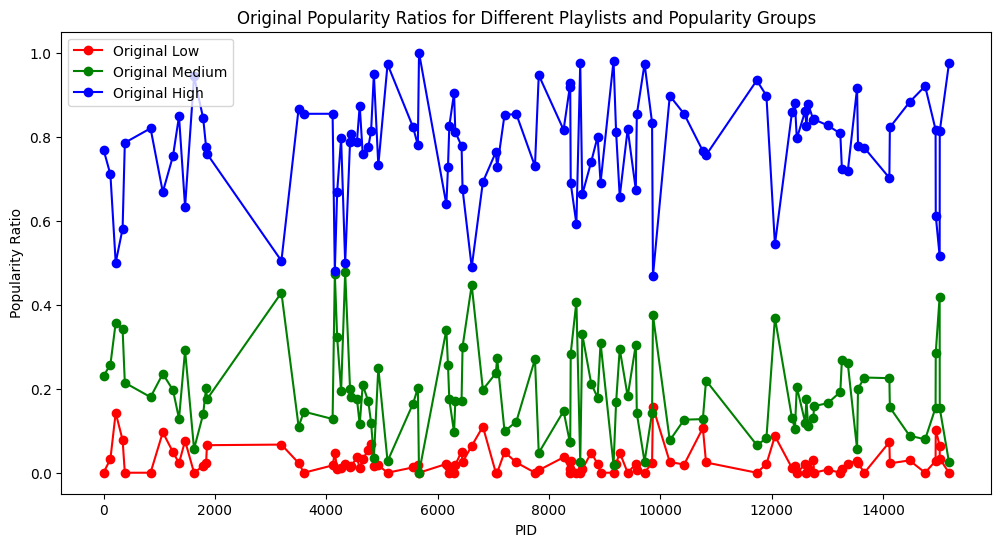

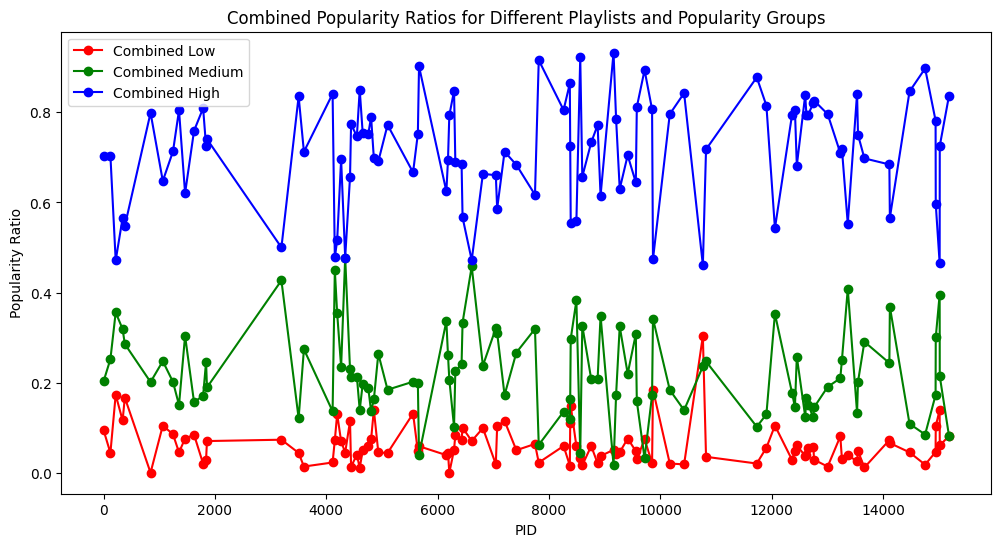

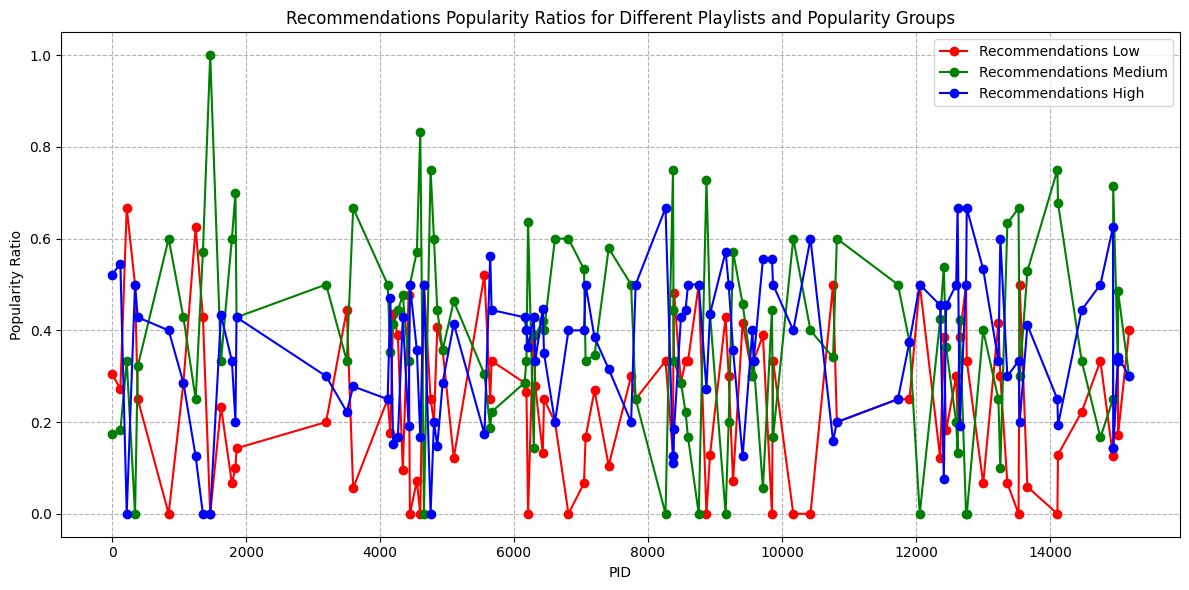

In [23]:
import matplotlib.pyplot as plt

# Define the colors for low, medium, and high popularity
colors = {'low': 'red', 'medium': 'green', 'high': 'blue'}

# Create three figures and axes for the plots
fig1, ax1 = plt.subplots(figsize=(12, 6))
fig2, ax2 = plt.subplots(figsize=(12, 6))
fig3, ax3 = plt.subplots(figsize=(12, 6))

# Define x-values (PID values)
x_values = list(recommendations_dict.keys())

# Iterate through the popularity groups (low, medium, high)
for popularity_group, color in colors.items():
    # Create lists to store y-values for the current popularity group
    y_values_original = []
    y_values_combined = []
    y_values_recommendations = []

    # Iterate through the PIDs to get popularity ratios for the current group
    for pid, data in recommendations_dict.items():
        original_ratios = data[pid]['original_popularity_ratios']
        combined_ratios = data[pid]['combined_popularity_ratios']
        recommendations_ratios = data[pid]['recommendations_popularity_ratios']

        # Append the ratios for the current popularity group
        y_values_original.append(original_ratios[popularity_group])
        y_values_combined.append(combined_ratios[popularity_group])
        y_values_recommendations.append(recommendations_ratios[popularity_group])

    # Plot the line for original ratios in the first graph
    ax1.plot(x_values, y_values_original, marker='o', label=f'Original {popularity_group.capitalize()}', color=color)

    # Plot the line for combined ratios in the second graph
    ax2.plot(x_values, y_values_combined, marker='o', label=f'Combined {popularity_group.capitalize()}', color=color)

    # Plot the line for recommendations ratios in the third graph
    ax3.plot(x_values, y_values_recommendations, marker='o', label=f'Recommendations {popularity_group.capitalize()}', color=color)

# Set labels and titles for all graphs
ax1.set_xlabel('PID')
ax1.set_ylabel('Popularity Ratio')
ax1.set_title('Original Popularity Ratios for Different Playlists and Popularity Groups')
ax1.legend()

ax2.set_xlabel('PID')
ax2.set_ylabel('Popularity Ratio')
ax2.set_title('Combined Popularity Ratios for Different Playlists and Popularity Groups')
ax2.legend()

ax3.set_xlabel('PID')
ax3.set_ylabel('Popularity Ratio')
ax3.set_title('Recommendations Popularity Ratios for Different Playlists and Popularity Groups')
ax3.legend()

# Show all three plots
plt.tight_layout()
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()


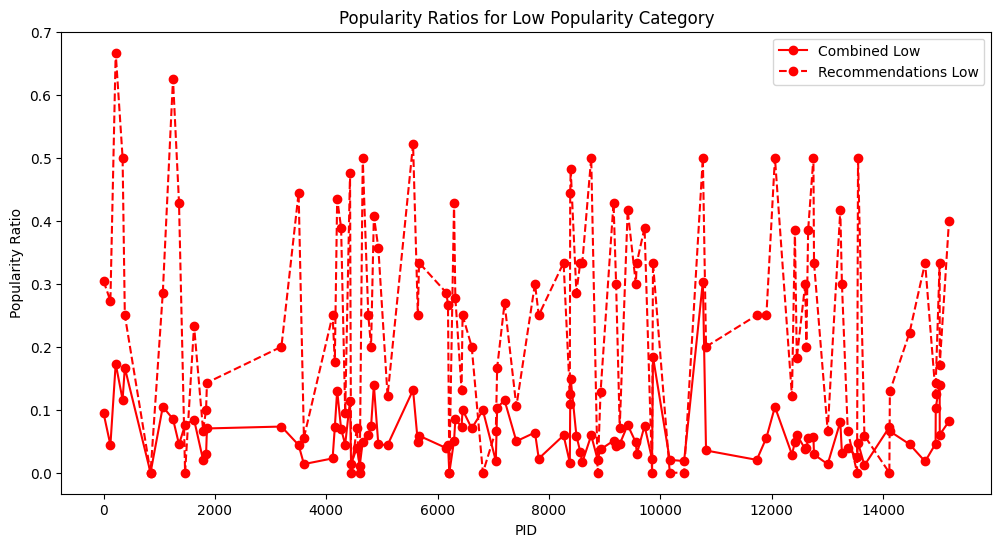

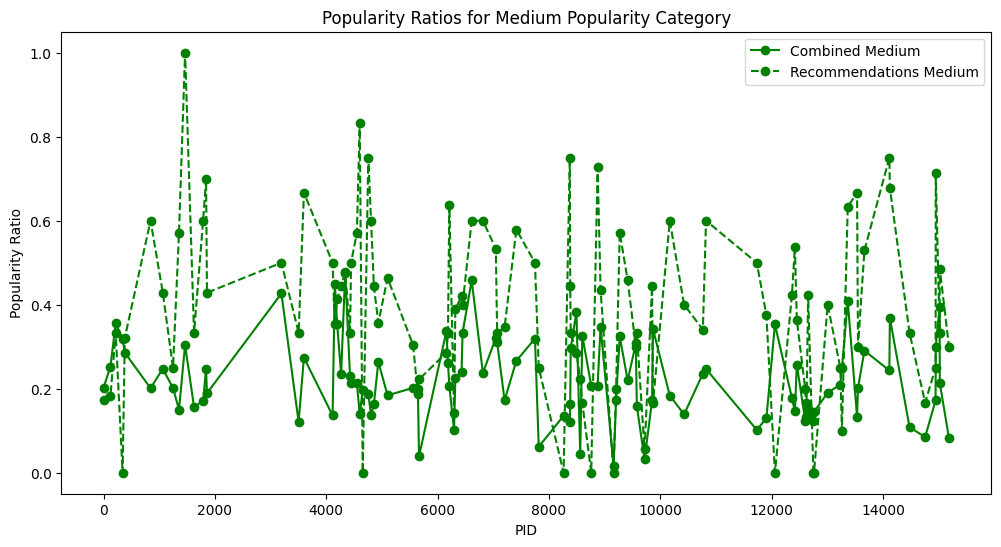

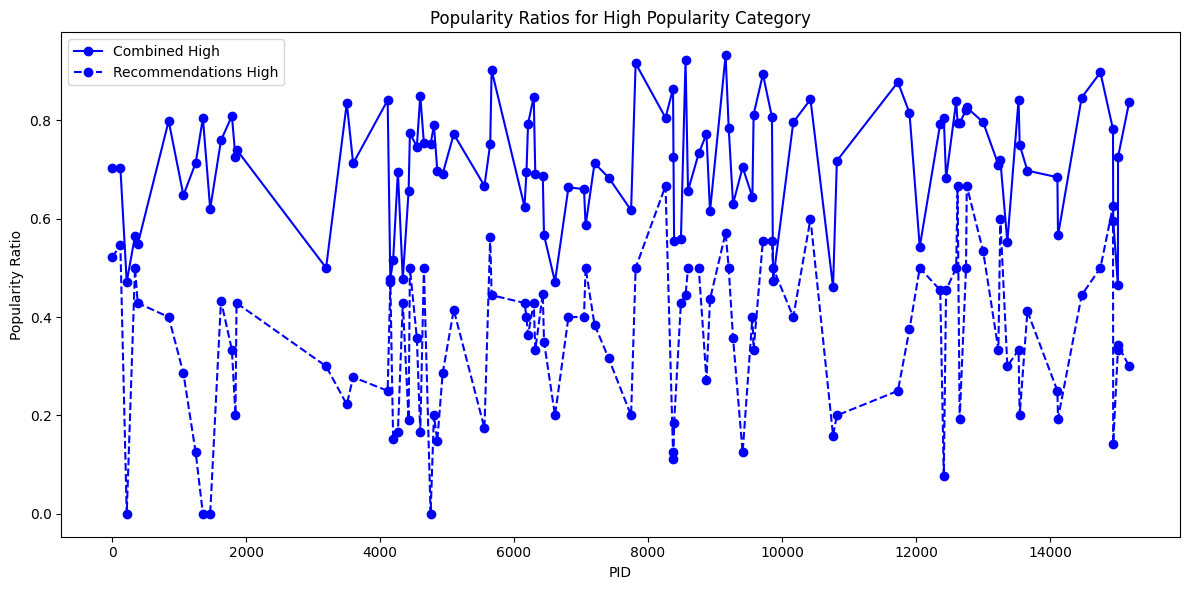

In [24]:
import matplotlib.pyplot as plt

# Define the colors for low, medium, and high popularity
colors = {'low': 'red', 'medium': 'green', 'high': 'blue'}

# Create three figures and axes for the plots (one for each popularity category)
fig_low, ax_low = plt.subplots(figsize=(12, 6))
fig_medium, ax_medium = plt.subplots(figsize=(12, 6))
fig_high, ax_high = plt.subplots(figsize=(12, 6))

# Define x-values (PID values)
x_values = list(recommendations_dict.keys())

# Iterate through the popularity groups (low, medium, high)
for popularity_group, color in colors.items():
    # Create lists to store y-values for the current popularity group (combined and recommendations)
    y_values_combined = []
    y_values_recommendations = []

    # Iterate through the PIDs to get popularity ratios for the current group
    for pid, data in recommendations_dict.items():
        combined_ratios = data[pid]['combined_popularity_ratios']
        recommendations_ratios = data[pid]['recommendations_popularity_ratios']

        # Append the ratios for the current popularity group
        y_values_combined.append(combined_ratios[popularity_group])
        y_values_recommendations.append(recommendations_ratios[popularity_group])

    # Plot the line for combined ratios in the corresponding graph
    if popularity_group == 'low':
        ax_low.plot(x_values, y_values_combined, marker='o', label=f'Combined Low', color=color)
    elif popularity_group == 'medium':
        ax_medium.plot(x_values, y_values_combined, marker='o', label=f'Combined Medium', color=color)
    else:  # popularity_group == 'high'
        ax_high.plot(x_values, y_values_combined, marker='o', label=f'Combined High', color=color)

    # Plot the line for recommendations ratios in the corresponding graph
    if popularity_group == 'low':
        ax_low.plot(x_values, y_values_recommendations, marker='o', linestyle='--', label=f'Recommendations Low', color=color)
    elif popularity_group == 'medium':
        ax_medium.plot(x_values, y_values_recommendations, marker='o', linestyle='--', label=f'Recommendations Medium', color=color)
    else:  # popularity_group == 'high'
        ax_high.plot(x_values, y_values_recommendations, marker='o', linestyle='--', label=f'Recommendations High', color=color)

# Set labels and titles for each plot
ax_low.set_xlabel('PID')
ax_low.set_ylabel('Popularity Ratio')
ax_low.set_title('Popularity Ratios for Low Popularity Category')

ax_medium.set_xlabel('PID')
ax_medium.set_ylabel('Popularity Ratio')
ax_medium.set_title('Popularity Ratios for Medium Popularity Category')

ax_high.set_xlabel('PID')
ax_high.set_ylabel('Popularity Ratio')
ax_high.set_title('Popularity Ratios for High Popularity Category')

# Add legends for each plot
ax_low.legend()
ax_medium.legend()
ax_high.legend()

# Show the plots
plt.tight_layout()
plt.show()


<ipython-input-25-565753e803d0>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_ratios, shade=True, label=f'Combined {popularity_group.capitalize()}', color=color, ax=ax_low)
<ipython-input-25-565753e803d0>:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recommendations_ratios, shade=True, label=f'Recommendations {popularity_group.capitalize()}', color=color, ax=ax_medium)
<ipython-input-25-565753e803d0>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_ratios, shade=True, label=f'Original {popularity_group.capitalize()}', color=color, ax=ax_high)
<ipython-input-25-565753e803d0>:35: FutureWarning: 


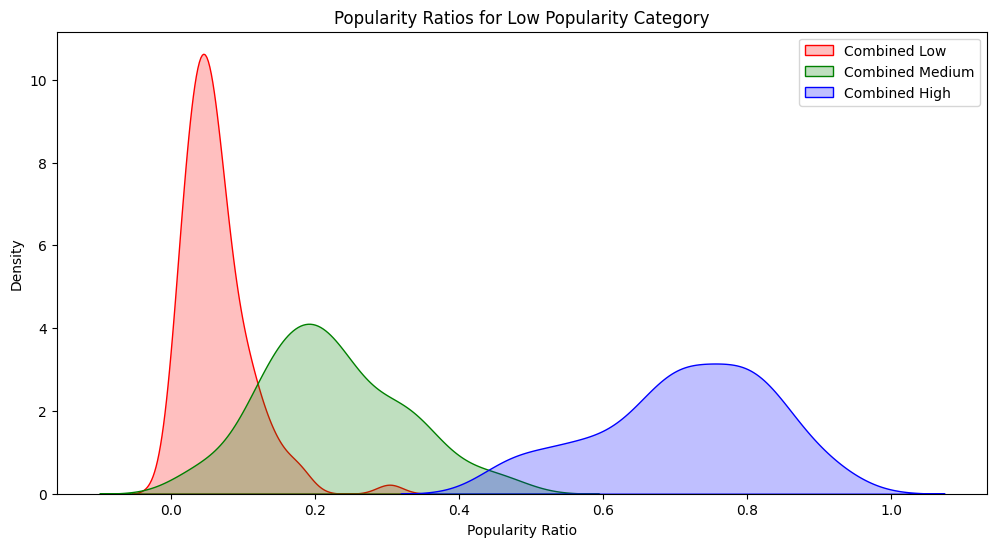

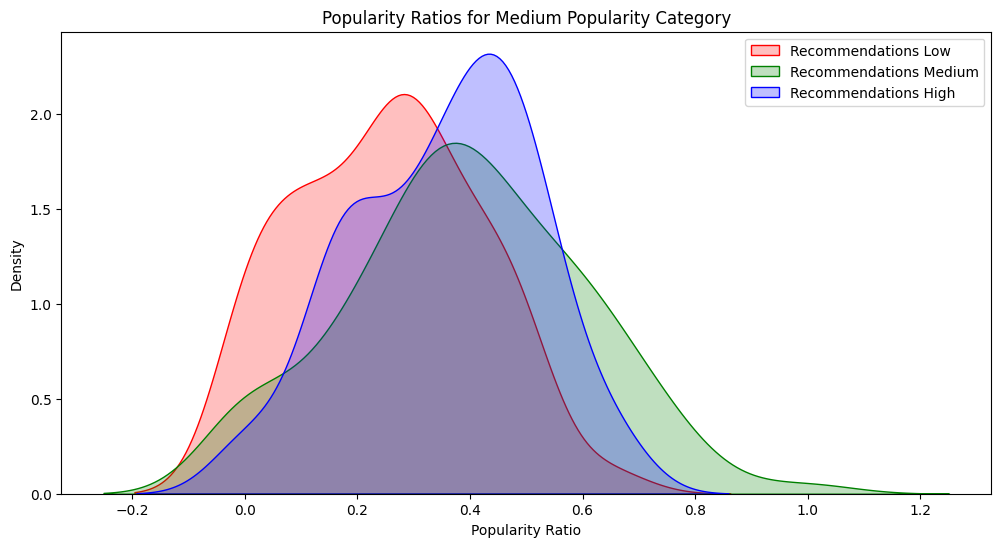

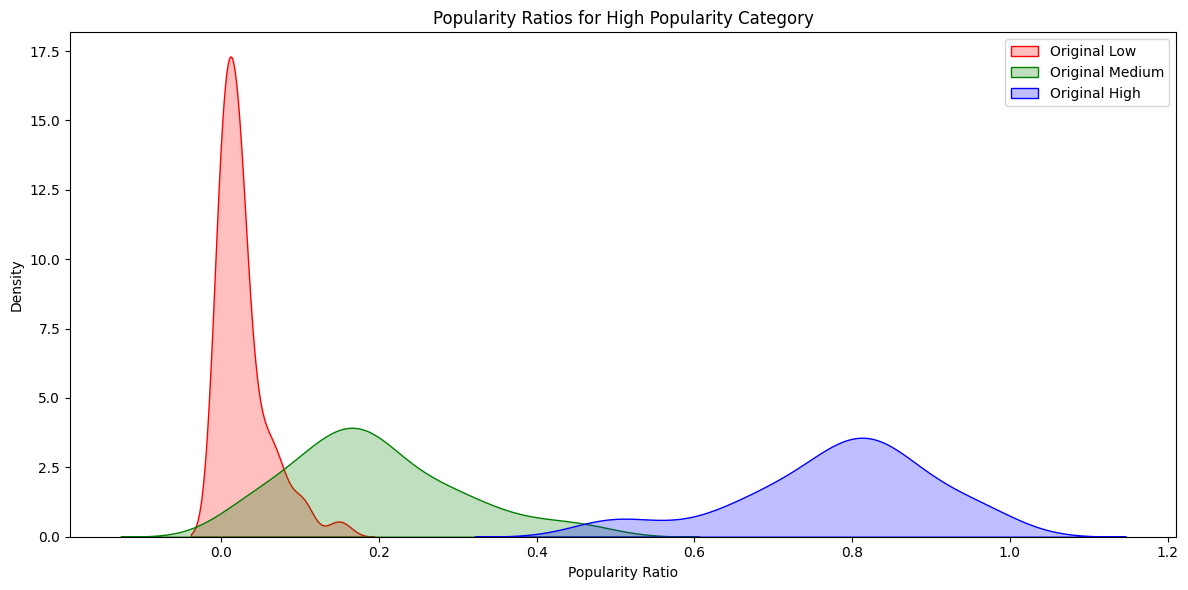

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the colors for low, medium, and high popularity
colors = {'low': 'red', 'medium': 'green', 'high': 'blue'}

# Create three figures and axes for the plots (one for each popularity category)
fig_low, ax_low = plt.subplots(figsize=(12, 6))
fig_medium, ax_medium = plt.subplots(figsize=(12, 6))
fig_high, ax_high = plt.subplots(figsize=(12, 6))

# Define x-values (PID values)
x_values = list(recommendations_dict.keys())

# Iterate through the popularity groups (low, medium, high)
for popularity_group, color in colors.items():
    # Create lists to store popularity ratios for the current popularity group (combined, recommended, and original)
    combined_ratios = []
    recommendations_ratios = []
    original_ratios = []

    # Iterate through the PIDs to get popularity ratios for the current group
    for pid, data in recommendations_dict.items():
        combined_ratio = data[pid]['combined_popularity_ratios'][popularity_group]
        recommendations_ratio = data[pid]['recommendations_popularity_ratios'][popularity_group]
        original_ratio = data[pid]['original_popularity_ratios'][popularity_group]

        # Append the ratios for the current popularity group
        combined_ratios.append(combined_ratio)
        recommendations_ratios.append(recommendations_ratio)
        original_ratios.append(original_ratio)

    # Create KDE plots for combined ratios in the corresponding graph with a specified color
    sns.kdeplot(combined_ratios, shade=True, label=f'Combined {popularity_group.capitalize()}', color=color, ax=ax_low)

    # Create KDE plots for recommendations ratios in the corresponding graph with a specified color
    sns.kdeplot(recommendations_ratios, shade=True, label=f'Recommendations {popularity_group.capitalize()}', color=color, ax=ax_medium)

    # Create KDE plots for original ratios in the corresponding graph with a specified color
    sns.kdeplot(original_ratios, shade=True, label=f'Original {popularity_group.capitalize()}', color=color, ax=ax_high)

# Set labels and titles for each plot
ax_low.set_xlabel('Popularity Ratio')
ax_low.set_ylabel('Density')
ax_low.set_title('Popularity Ratios for Low Popularity Category')

ax_medium.set_xlabel('Popularity Ratio')
ax_medium.set_ylabel('Density')
ax_medium.set_title('Popularity Ratios for Medium Popularity Category')

ax_high.set_xlabel('Popularity Ratio')
ax_high.set_ylabel('Density')
ax_high.set_title('Popularity Ratios for High Popularity Category')

# Add legends for each plot
ax_low.legend()
ax_medium.legend()
ax_high.legend()

# Show the plots
plt.tight_layout()
plt.show()


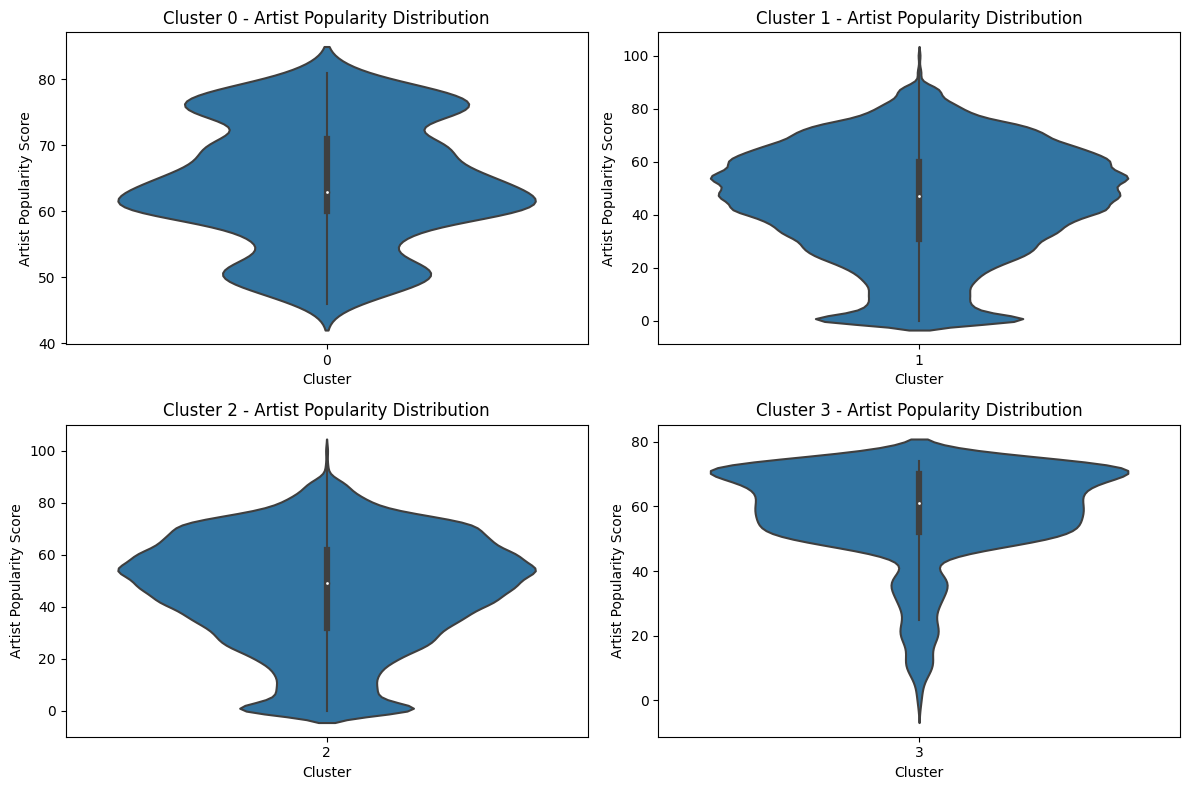

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the two DataFrames based on track_id
merged_df = tracks_df_clustered.merge(tracks_df[['track_id', 'artist_popularity']], on='track_id', how='left')

# Set up the subplots for Artist Popularity Score using violin plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot violin plots for Artist Popularity Score in each cluster
for i, cluster_value in enumerate([0, 1, 2, 3]):
    sns.violinplot(x='cluster', y='artist_popularity_y', data=merged_df[merged_df['cluster'] == cluster_value], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Cluster {cluster_value} - Artist Popularity Distribution')
    axes[i // 2, i % 2].set_xlabel('Cluster')
    axes[i // 2, i % 2].set_ylabel('Artist Popularity Score')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [28]:
import scipy.stats as stats

# Perform the Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(original_ratios, recommendations_ratios, alternative='two-sided')

# Output the test statistic and p-value
print("Mann-Whitney U Statistic:", statistic)
print("P-Value:", p_value)

# Determine the significance level (alpha)
alpha = 0.05  # You can choose the significance level based on your desired confidence level

# Compare the p-value to the significance level to make a decision
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between original and recommended ratios.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between original and recommended ratios.")






Mann-Whitney U Statistic: 9817.0
P-Value: 5.451869753255841e-32
Reject the null hypothesis: There is a significant difference between original and recommended ratios.
